#Import Libraries    

In [ ]:
pip install kneed

In [ ]:
import pandas as pd
import numpy as np

import time

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from datetime import datetime
from sklearn import model_selection, preprocessing

# python core library for machine learning and data science
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

from kneed import KneeLocator

RANDOM_STATE = 42



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Data

In [ ]:
df_weekly_items_sales = pd.read_csv('/content/drive/MyDrive/ds_market/weekly_items_sales.csv', index_col=0)

In [ ]:
df_weekly_items_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8354260 entries, 0 to 8354259
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   id                  object 
 1   item                object 
 2   category            object 
 3   department          object 
 4   store               object 
 5   store_code          object 
 6   region              object 
 7   date                object 
 8   quantity            int64  
 9   event               int64  
 10  sell_price          float64
 11  sell_price_imputed  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 828.6+ MB


#Format Data & Initial EDA

In [ ]:
# specify the format since otherwise it might give some problems
df_weekly_items_sales["date"] = pd.to_datetime(df_weekly_items_sales["date"], format = "%Y-%m-%d")
df_weekly_items_sales.drop('sell_price', axis=1, inplace=True)
df_weekly_items_sales.rename(columns={'sell_price_imputed': 'sell_price'}, inplace=True)

In [ ]:
df_weekly_items_sales.isnull().sum()

id            0
item          0
category      0
department    0
store         0
store_code    0
region        0
date          0
quantity      0
event         0
sell_price    0
dtype: int64

In [ ]:
df_weekly_items_sales.head()

,id,item,category,department,store,store_code,region,date,quantity,event,sell_price
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,0,0,12.7414
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-06,0,1,12.7414
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-13,0,0,12.7414
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-20,0,0,12.7414
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-27,0,0,12.7414


In [ ]:
df_weekly_items_sales.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
quantity,8354260.0,7.863702,23.680201,0.000,0.0000,2.000,7.000,3976.00
event,8354260.0,0.094891,0.293064,0.000,0.0000,0.000,0.000,1.00
sell_price,8354260.0,5.562442,4.547930,0.012,2.6201,4.176,7.176,134.15


## Categorical EDA

In [ ]:
df_categorical_col = df_weekly_items_sales.describe(exclude=np.number).T
df_categorical_col['total'] = df_categorical_col['unique'] * df_categorical_col['freq']
df_categorical_col

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,count,unique,top,freq,first,last,total
id,8354260,30490,ACCESORIES_1_001_BOS_1,274,NaT,NaT,8354260
item,8354260,3049,ACCESORIES_1_001,2740,NaT,NaT,8354260
category,8354260,3,SUPERMARKET,3937380,NaT,NaT,11812140
department,8354260,7,SUPERMARKET_3,2255020,NaT,NaT,15785140
store,8354260,10,South_End,835426,NaT,NaT,8354260
store_code,8354260,10,BOS_1,835426,NaT,NaT,8354260
region,8354260,3,New York,3341704,NaT,NaT,10025112
date,8354260,274,2011-01-30 00:00:00,30490,2011-01-30,2016-04-24,8354260


#Creacion Variables max, min, median, q1,q3,iqr

Creamos nuevas variables a partir de los datos que tenemos para poder genera una mejor interacción del algoritmo.

In [ ]:
df_weekly_items_sales["revenue"] = df_weekly_items_sales["quantity"] * df_weekly_items_sales["sell_price"]

In [ ]:
df_weekly_items_sales["event_quantity"] = df_weekly_items_sales["quantity"] * df_weekly_items_sales["event"]

In [ ]:
df_id_max_sell = df_weekly_items_sales.groupby(['item'])['sell_price'].max()
df_id_min_sell = df_weekly_items_sales.groupby(['item'])['sell_price'].min()


Hacemos un merge entre sell_price_min y sell_price_max

In [ ]:
df_id_ = pd.merge(df_id_max_sell, df_id_min_sell, on = 'item', suffixes=('_max', '_min'))
df_id_.head()

,sell_price_max,sell_price_min
item,,
ACCESORIES_1_001,12.7414,6.6500
ACCESORIES_1_002,5.2801,2.6600
ACCESORIES_1_003,7.9401,1.2502
ACCESORIES_1_004,6.1712,5.0141
ACCESORIES_1_005,4.0964,1.9950


In [ ]:
df_id_median= df_weekly_items_sales.groupby(['item'])['sell_price'].median()

Añadimos la mediana

In [ ]:
df_id_= pd.merge(df_id_, df_id_median, on = 'item', suffixes=('_median'))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing 'suffixes' as a <class 'str'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  """Entry point for launching an IPython kernel.


In [ ]:
df_id_.rename(columns={'sell_price':'sell_price_median'},inplace = True)

In [ ]:
df_id_.head(1)

,sell_price_max,sell_price_min,sell_price_median
item,,,
ACCESORIES_1_001,12.7414,6.65,10.9858


In [ ]:
df_vals = df_weekly_items_sales[['item','sell_price']]

Creamos los Quantiles

In [ ]:
df_q1= df_vals.groupby(['item']).quantile(.25)

In [ ]:
df_q3= df_vals.groupby(['item']).quantile(.75)

In [ ]:
df_q = pd.merge(df_q1, df_q3, on = 'item', suffixes=('_q1', '_q3'))
df_q.head()

,sell_price_q1,sell_price_q3
item,,
ACCESORIES_1_001,10.9858,11.4646
ACCESORIES_1_002,5.2801,5.2801
ACCESORIES_1_003,3.9501,3.9501
ACCESORIES_1_004,5.7722,6.1712
ACCESORIES_1_005,3.6309,3.9634


In [ ]:
df_q['iqr'] = df_q['sell_price_q3']-df_q['sell_price_q1']
df_q.head()

,sell_price_q1,sell_price_q3,iqr
item,,,
ACCESORIES_1_001,10.9858,11.4646,0.4788
ACCESORIES_1_002,5.2801,5.2801,0.0000
ACCESORIES_1_003,3.9501,3.9501,0.0000
ACCESORIES_1_004,5.7722,6.1712,0.3990
ACCESORIES_1_005,3.6309,3.9634,0.3325


#merge id & q

In [ ]:
df_id_.shape

(3049, 3)

In [ ]:
df_q.shape

(3049, 3)

In [ ]:
df_id_ = pd.merge(df_id_,df_q, on= 'item')

#items sales df

Agrupamos por item y agregamos varias variables

In [ ]:
# # set index
df_items_sales = df_weekly_items_sales.set_index("item")

# # groupby shop_id and item_id
df_items_sales = df_items_sales.groupby(['item']).agg({
  'quantity':np.sum, 
  "sell_price":np.mean, 
  "revenue":np.sum, 
  "event_quantity": np.sum,
  "category": lambda serie: serie.unique(),
  "department": lambda serie: serie.unique(),
  
  })

# # convert to dataframe and save the full dataframe
df_items_sales.reset_index(inplace = True)
df_items_sales

,item,quantity,sell_price,revenue,event_quantity,category,department
0,ACCESORIES_1_001,4093,11.470706,45037.9230,415,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,5059,5.276746,26708.0758,447,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,1435,3.947629,5656.3437,146,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,39175,5.977661,235347.8358,3665,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,14621,3.838264,55670.1292,1311,ACCESORIES,ACCESORIES_1
...,...,...,...,...,...,...,...
3044,SUPERMARKET_3_823,15388,3.345153,50854.0440,1164,SUPERMARKET,SUPERMARKET_3
3045,SUPERMARKET_3_824,8325,3.026768,25414.5600,672,SUPERMARKET,SUPERMARKET_3
3046,SUPERMARKET_3_825,13526,4.933888,65787.5640,1136,SUPERMARKET,SUPERMARKET_3
3047,SUPERMARKET_3_826,12188,1.535877,18719.7600,1135,SUPERMARKET,SUPERMARKET_3


In [ ]:
df_items_sales.shape

(3049, 7)

In [ ]:
df_id_.shape

(3049, 6)

#merge max & min sell price con item sales 

Creamos un df combinando las variables creadas con el dataframe de items juntando por item

In [ ]:
df_final_1 = pd.merge(df_items_sales, df_id_, on = 'item')
df_final_1

,item,quantity,sell_price,revenue,event_quantity,category,department,sell_price_max,sell_price_min,sell_price_median,sell_price_q1,sell_price_q3,iqr
0,ACCESORIES_1_001,4093,11.470706,45037.9230,415,ACCESORIES,ACCESORIES_1,12.7414,6.6500,10.9858,10.9858,11.4646,0.4788
1,ACCESORIES_1_002,5059,5.276746,26708.0758,447,ACCESORIES,ACCESORIES_1,5.2801,2.6600,5.2801,5.2801,5.2801,0.0000
2,ACCESORIES_1_003,1435,3.947629,5656.3437,146,ACCESORIES,ACCESORIES_1,7.9401,1.2502,3.9501,3.9501,3.9501,0.0000
3,ACCESORIES_1_004,39175,5.977661,235347.8358,3665,ACCESORIES,ACCESORIES_1,6.1712,5.0141,6.1712,5.7722,6.1712,0.3990
4,ACCESORIES_1_005,14621,3.838264,55670.1292,1311,ACCESORIES,ACCESORIES_1,4.0964,1.9950,3.8304,3.6309,3.9634,0.3325
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,SUPERMARKET_3_823,15388,3.345153,50854.0440,1164,SUPERMARKET,SUPERMARKET_3,3.5760,1.1880,3.4560,3.2160,3.5760,0.3600
3045,SUPERMARKET_3_824,8325,3.026768,25414.5600,672,SUPERMARKET,SUPERMARKET_3,3.2160,2.4000,3.2160,2.9760,3.2160,0.2400
3046,SUPERMARKET_3_825,13526,4.933888,65787.5640,1136,SUPERMARKET,SUPERMARKET_3,5.2560,2.3880,4.7760,4.7760,5.2560,0.4800
3047,SUPERMARKET_3_826,12188,1.535877,18719.7600,1135,SUPERMARKET,SUPERMARKET_3,1.5360,1.2000,1.5360,1.5360,1.5360,0.0000


In [ ]:
df_final_1= df_final_1.set_index('item')

#outliers 

Miramos los outliers que tenemos, en principio tenemos unos poco outliers extremos que trataremos más adelante para el df de train

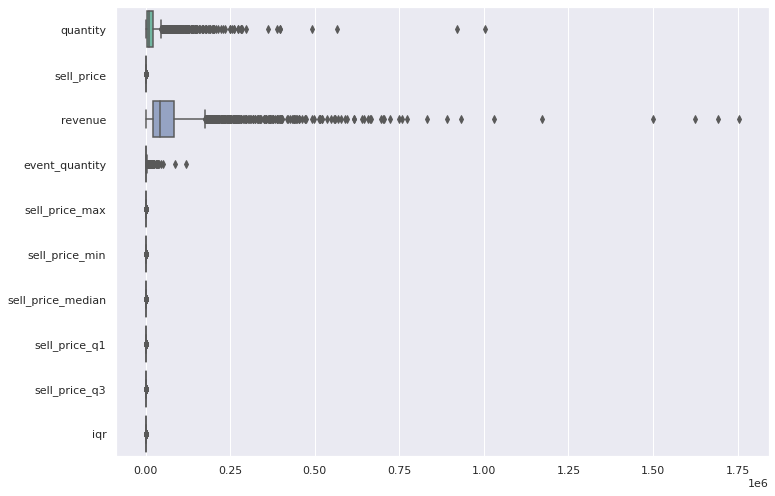

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(data=df_final_1, orient="h", palette="Set2")

In [ ]:
df_final_1.drop(['department', 'category'], axis = 1, inplace = True)

#df_train no outliers

Filtramos los outliers con un quantile < 0.99 con el fin de no generar un cluster con outliers muy muy extremos como se observa en la gráfica anterior

In [ ]:
df_train = df_final_1[(df_final_1["revenue"] < np.quantile(df_final_1["revenue"], q = 0.99)) & (df_final_1["quantity"] < np.quantile(df_final_1["quantity"], q = 0.99))]

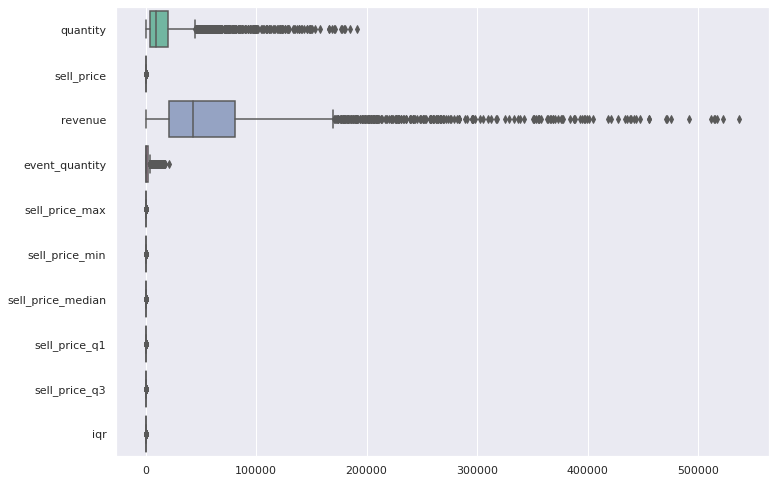

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(data=df_train, orient="h", palette="Set2")

#Scaler

Estandarizamos los datos para introducir al modelo.

In [ ]:
# Escalado de datos Train
standard_scaler = StandardScaler()
scaled_df = standard_scaler.fit_transform(df_train)
scaled_df = pd.DataFrame(scaled_df, index = df_train.index, columns = df_train.columns)

Para el dataframe de predict usaremos el df completo "df_final_1" tiene todos los elementos completos.

In [ ]:
# Escalado de datos Predict
standard_scaler = StandardScaler()
scaled_df_pred = standard_scaler.fit_transform(df_final_1)
scaled_df_pred = pd.DataFrame(scaled_df_pred, index = df_final_1.index, columns = df_final_1.columns)

In [ ]:
scaled_df.shape

(2999, 10)

In [ ]:
scaled_df_pred.shape

(3049, 10)

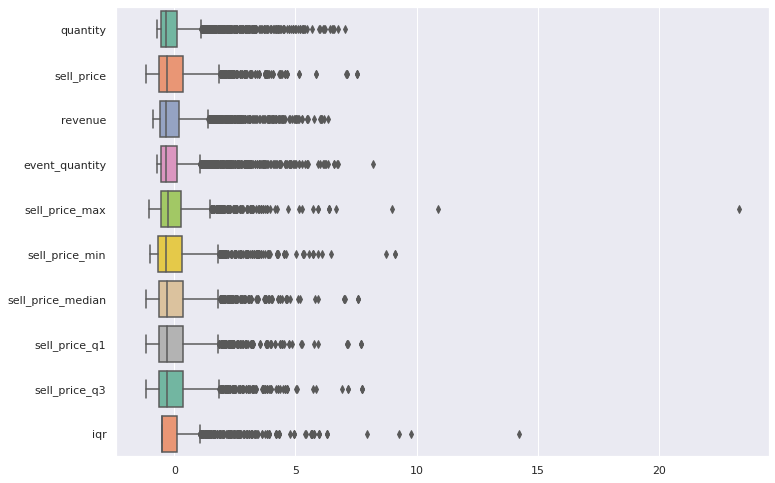

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(data=scaled_df, orient="h", palette="Set2")

#Elbow

Dibujamos la gráfica de elbow para mirar la recomendación de n_clusters

In [ ]:
sse = {}

for k in range(2, 15):
    print(f"Fitting pipe with {k} clusters")
    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(scaled_df)
    sse[k] = clustering_model.inertia_


Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


In [ ]:
sse

{2: 19214.132014448023,
 3: 14318.604033311261,
 4: 11249.702547248602,
 5: 10033.65855401237,
 6: 8980.605886149458,
 7: 8043.931131798421,
 8: 7366.27798843643,
 9: 6756.068030419315,
 10: 6380.653167402661,
 11: 5952.758309496465,
 12: 5731.700594252605,
 13: 5272.630039811145,
 14: 5009.536085124735}

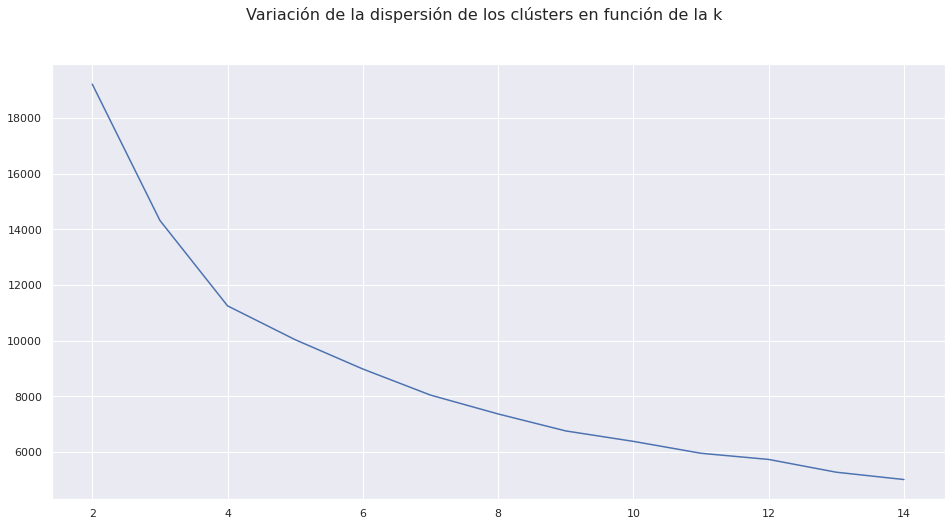

In [ ]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

#Alternative Elbow

Una segunda opción de gráfico e interpretación de los datos para poder hacer un double check de la decisión del n_clusters.

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_df)
  sse.append(kmeans.inertia_)

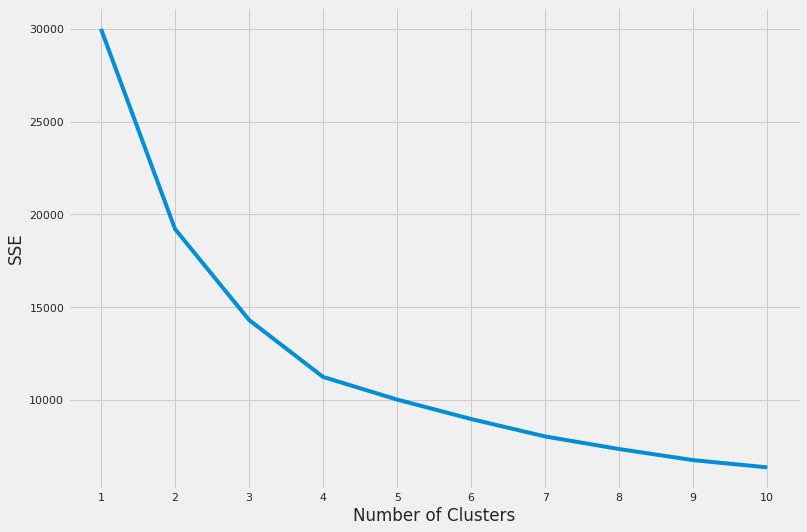

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

#Kmeans

Generamos los clusters a partir de lo recomendado por los elbows y el KneeLocator (función que nos indica el punto en el cual la pendiente tiene mayor variación por ende nos indica el número de clusters recomendado

In [ ]:
clustering_model = KMeans(n_clusters = 4, random_state=42)
clustering_model.fit(scaled_df)

KMeans(n_clusters=4, random_state=42)

In [ ]:
clustering_model.cluster_centers_

array([[-0.40848831,  0.69870443,  0.00354625, -0.4042876 ,  0.60058524,
         0.58786107,  0.69212961,  0.69121667,  0.70164691,  0.32669063],
       [-0.43236475,  2.96976217,  0.84059686, -0.424267  ,  2.76371451,
         2.67581771,  2.97934718,  2.95678808,  2.97208882,  1.08047255],
       [-0.16119476, -0.48536067, -0.3157491 , -0.16391926, -0.43543438,
        -0.43477425, -0.48364094, -0.4809738 , -0.48687473, -0.2126519 ],
       [ 2.71735102, -0.65628787,  1.70020856,  2.71839454, -0.57145096,
        -0.47885034, -0.65424771, -0.65574039, -0.65619442, -0.20783883]])

In [ ]:
labels = clustering_model.predict(scaled_df_pred)
df_final_1["cluster"] = labels

##Graphs

Generación de gráfico en 2D a fin de poder visualizar la distribución, con un PCA reducimos las dimensiones a 2D

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(2)

In [ ]:
df = pca.fit_transform(scaled_df)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)

In [ ]:
label = kmeans.fit_predict(df)

In [ ]:
u_labels = np.unique(label)

In [ ]:
centroids = kmeans.cluster_centers_

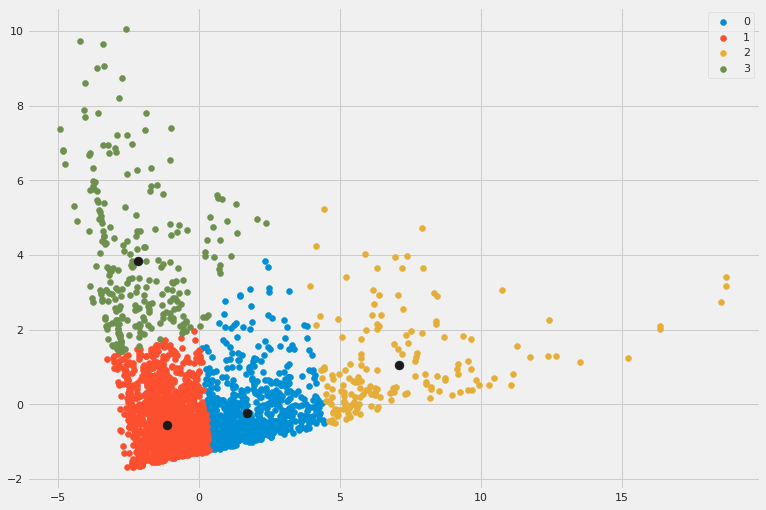

In [ ]:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

## File for Power BI

Importamos el dataframe para poder generar el mismo gráfico en Power BI

In [ ]:
clus = pd.DataFrame(df)

In [ ]:
clus['cluster']= label

In [ ]:
from google.colab import files
clus.to_excel('clus.xlsx') 
files.download('clus.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#df with clusters

In [ ]:
df_final_1.reset_index(inplace = True)

In [ ]:
df_final_1.head(1)

,item,quantity,sell_price,revenue,event_quantity,sell_price_max,sell_price_min,sell_price_median,sell_price_q1,sell_price_q3,iqr,cluster
0,ACCESORIES_1_001,4093,11.470706,45037.923,415,12.7414,6.65,10.9858,10.9858,11.4646,0.4788,0


#Cluster df

Creamos un df con los clusters incluidos para poder exportar el listado en base a los clusters

In [ ]:
df_id_count = df_final_1.groupby(['cluster'])['item'].count()
df_id_count

cluster
0     808
1     162
2    1915
3     164
Name: item, dtype: int64

In [ ]:
cluster_df = pd.merge(df_final_1, df_id_count, on = 'cluster')

In [ ]:
cluster_df.head(1)

,item_x,quantity,sell_price,revenue,event_quantity,sell_price_max,sell_price_min,sell_price_median,sell_price_q1,sell_price_q3,iqr,cluster,item_y
0,ACCESORIES_1_001,4093,11.470706,45037.923,415,12.7414,6.65,10.9858,10.9858,11.4646,0.4788,0,808


In [ ]:
cluster_df.rename(columns = {'item_x':'item', 'item_y':'item_count'}, inplace = True)

In [ ]:
#Lista de elementos
export_list = cluster_df.pivot_table(index= ['cluster'], values = ['item'],aggfunc=lambda x: ', '.join(x))

In [ ]:
pd.set_option('display.max_colwidth', None)
lista_clusters = cluster_df.groupby(['cluster']).agg({
    'quantity':np.sum, 
    "sell_price":np.mean, 
    "revenue":np.sum, 
    "event_quantity": np.sum,
    "item_count": np.mean
})

lista_clusters

,quantity,sell_price,revenue,event_quantity,item_count
cluster,,,,,
0,7300848,8.737489,6.189287e+07,675491,808.0
1,1194348,19.233085,2.222684e+07,113217,162.0
2,32205549,3.334865,9.332377e+07,3012508,1915.0
3,24994664,2.426648,5.350782e+07,2374015,164.0


#Graphs

Creamos gráficos para visualizar e interpretar los resultados

In [ ]:
df_final_1.head(1)

,item,quantity,sell_price,revenue,event_quantity,sell_price_max,sell_price_min,sell_price_median,sell_price_q1,sell_price_q3,iqr,cluster
0,ACCESORIES_1_001,4093,11.470706,45037.923,415,12.7414,6.65,10.9858,10.9858,11.4646,0.4788,0


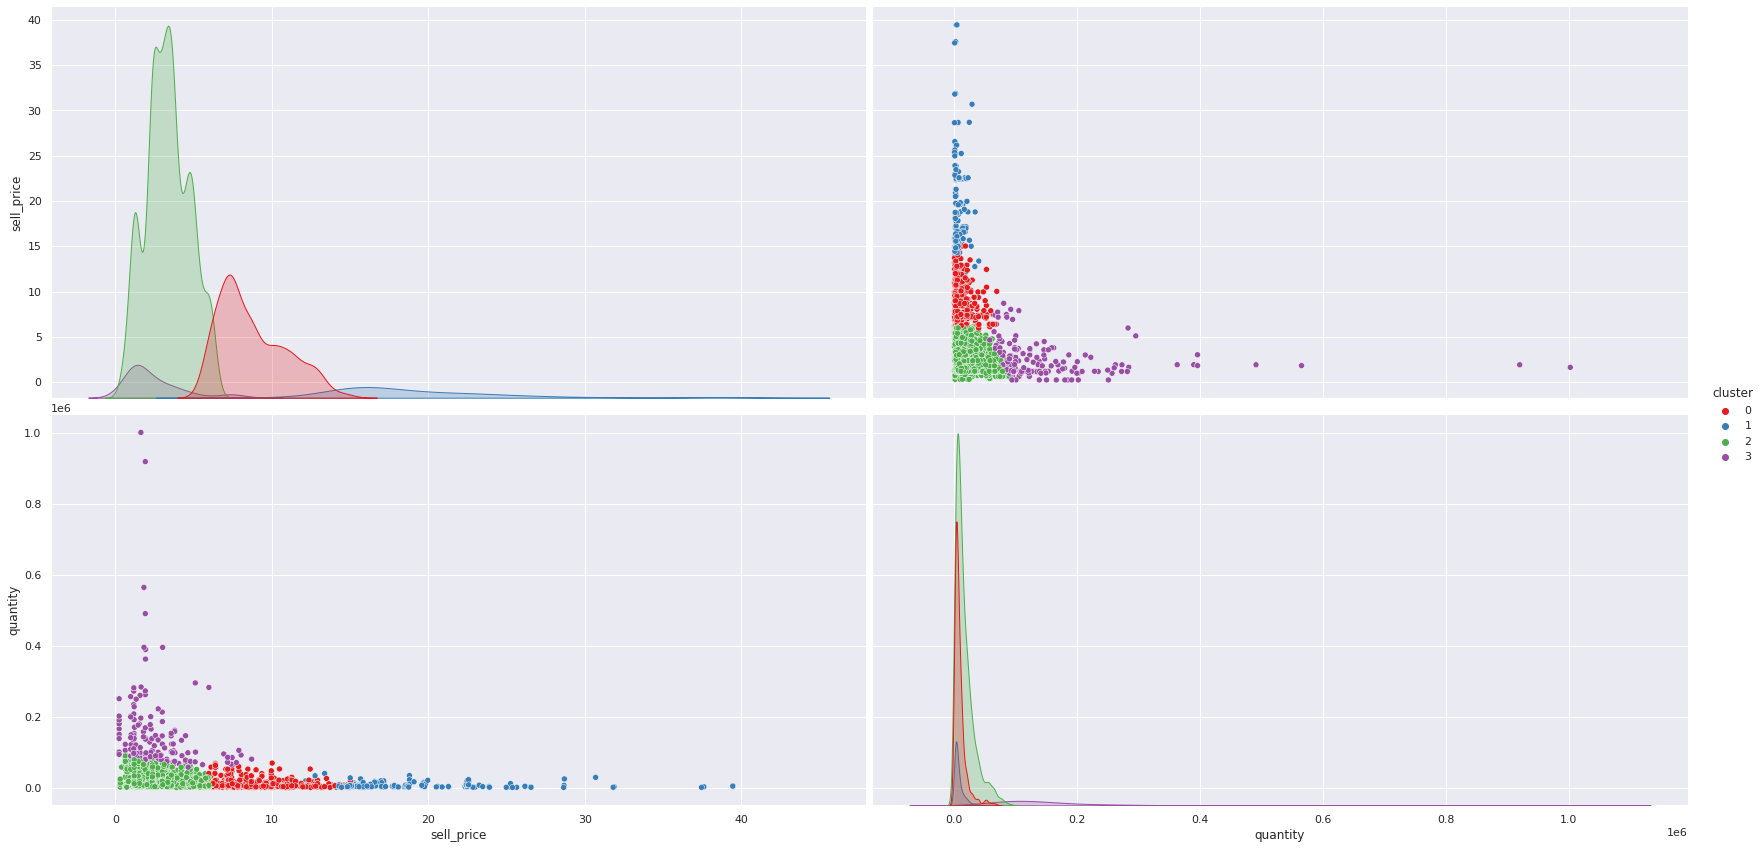

In [ ]:
sns.pairplot(df_final_1, vars = ['sell_price', 'quantity'], hue = 'cluster',height=6, aspect = 2, palette = 'Set1');

In [ ]:
selected_columns = [
  'quantity', 
  'sell_price',
  'iqr', 
  'revenue', 
  'event_quantity',
  

  
]

In [ ]:
ficha_df = pd.DataFrame()

In [ ]:
for i, col in enumerate(selected_columns):
    resumen_data = df_final_1[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = ficha_df.append(resumen_data)

In [ ]:
ficha_df

cluster                          0              1              2             3
quantity       mean    9035.702970    7372.518519   16817.519060  1.524065e+05
               std    10101.680361    7256.319114   16000.410604  1.207788e+05
               min      718.000000     855.000000     568.000000  5.813300e+04
               25%     3041.500000    2667.750000    5581.000000  9.194325e+04
               50%     5714.500000    4534.000000   11555.000000  1.190820e+05
               75%    11100.500000    9079.500000   22675.500000  1.670912e+05
               max    69608.000000   40354.000000   94454.000000  1.002529e+06
sell_price     mean       8.737489      19.233085       3.334865  2.426648e+00
               std        2.134882       5.683603       1.386850  1.830596e+00
               min        5.631145       8.742815       0.240644  2.395226e-01
               25%        7.152552      15.296474       2.376000  1.196388e+00
               50%        8.219487      17.150607       3.302672  1.909993e+00
               75%       10.255637      22.435387       4.350828  3.123611e+00
               max       15.030753      39.447169       6.608144  8.703832e+00
iqr            mean       0.352914       0.688520       0.121971  1.282140e-01
               std        0.540766       1.024957       0.200593  2.189595e-01
               min        0.000000       0.000000       0.000000  0.000000e+00
               25%        0.000000       0.000000       0.000000  0.000000e+00
               50%        0.006000       0.012500       0.000000  3.750000e-02
               75%        0.611975       1.250000       0.216000  2.160000e-01
               max        2.892000       6.250000       1.995000  1.608000e+00
revenue        mean   76600.084383  137202.740567   48733.038413  3.262672e+05
               std    84616.603482  141486.170792   44294.415447  2.932913e+05
               min     4111.837500   14606.113200     558.879300  2.259488e+04
               25%    26318.784000   49063.196875   17633.791000  1.467682e+05
               50%    47070.225250   80635.936800   35760.487500  2.485250e+05
               75%    91579.100000  185717.904750   64941.548000  3.905163e+05
               max   696176.725000  890942.528000  296594.304000  1.754296e+06
event_quantity mean     836.003713     698.870370    1573.111227  1.447570e+04
               std      918.801140     696.131120    1539.421667  1.259943e+04
               min       48.000000      77.000000      45.000000  4.878000e+03
               25%      288.000000     257.500000     503.000000  8.573000e+03
               50%      530.500000     413.000000    1059.000000  1.081400e+04
               75%     1018.250000     857.000000    2069.500000  1.606050e+04
               max     6897.000000    3777.000000    8993.000000  1.190810e+05

In [ ]:
# generamos nuestro multiindex
out_index = [
    "Sales",
    "Sales",
    'Sales',
    'Sales',
    "Event",
   
    
    
]

inner_index = [
    "Quantity",
    "Price",
    'IQR',
    "Revenue",
    "Quantity",
    

    
    
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))
        
new_multi_index

[('Sales', 'Quantity', 'Media'),
 ('Sales', 'Quantity', 'Desviación'),
 ('Sales', 'Quantity', 'Mínimo'),
 ('Sales', 'Quantity', 'Perc. 25'),
 ('Sales', 'Quantity', 'Perc. 50'),
 ('Sales', 'Quantity', 'Perc. 75'),
 ('Sales', 'Quantity', 'Máximo'),
 ('Sales', 'Price', 'Media'),
 ('Sales', 'Price', 'Desviación'),
 ('Sales', 'Price', 'Mínimo'),
 ('Sales', 'Price', 'Perc. 25'),
 ('Sales', 'Price', 'Perc. 50'),
 ('Sales', 'Price', 'Perc. 75'),
 ('Sales', 'Price', 'Máximo'),
 ('Sales', 'IQR', 'Media'),
 ('Sales', 'IQR', 'Desviación'),
 ('Sales', 'IQR', 'Mínimo'),
 ('Sales', 'IQR', 'Perc. 25'),
 ('Sales', 'IQR', 'Perc. 50'),
 ('Sales', 'IQR', 'Perc. 75'),
 ('Sales', 'IQR', 'Máximo'),
 ('Sales', 'Revenue', 'Media'),
 ('Sales', 'Revenue', 'Desviación'),
 ('Sales', 'Revenue', 'Mínimo'),
 ('Sales', 'Revenue', 'Perc. 25'),
 ('Sales', 'Revenue', 'Perc. 50'),
 ('Sales', 'Revenue', 'Perc. 75'),
 ('Sales', 'Revenue', 'Máximo'),
 ('Event', 'Quantity', 'Media'),
 ('Event', 'Quantity', 'Desviación'),
 ('E

In [ ]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [ ]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [ ]:
tamaño_clusters = df_final_1.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [ ]:
ficha_df = tamaño_clusters.append(ficha_df)

In [ ]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

# Conclusiones de Clusters


- Cluster 0: Contiene los elementos que tienen un precio medio, es decir pensado para clientes que tengan un alcance medio, medio-alto. 
  - Variación de precio: 5- 15 €
  - Precio Medio: 8,70 €
  - Alcance económico Cliente :  Medio

- Cluster 1: contiene los elementos que son de mayor precio, es decir aquellos que se pueden controlar para clientes con alto alcance económico, productos luxurie.
  - Variación de precio: 8,75 - 39 €
  - Precio medio: 19 €
  - Alcance económico: Alto

- Cluster 2: contiene la mayor cantidad de items, se venden en grandes cantidades, el precio NO es el más bajo pero no llega a ser un precio medio.
  - Variación de precio: 0,30 - 6 €
  - Precio medio: 3,40 €
  - Alcance económico cliente: Bajo, Medio-Bajo

- Cluster 3: Contiene los elementos que más se venden, por lo tanto presentan un gran ingreso de revenue, se debe considerar que el precio de venta es el más bajo, por lo que el target de cliente serían aquellos que compran en grandes cantidades los productos non-luxurie. (masivos).
  - Variación de precio: 0,24 -9,26 €
  - Precio Medio: 2,562 €
  - Alcance económico Cliente :  Bajo

#Export List

Exportación del listado de items por cada cluster.

In [ ]:
export_list.head()

item
cluster                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [ ]:

from google.colab import files
export_list.to_excel('cluster_list.xlsx') 
files.download('cluster_list.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>